Copyright (c) 2023 Habana Labs, Ltd. an Intel Company.
### Licensed under the Apache License, Version 2.0 (the "License");  
You may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# PyTorch U-Net 2D: Semantic Segmentation for Autonomous Driving

## Table of Contents
- [Introduction and Setup](#introduction)
- [Data Exploration](#data-exploration)
- [Pytorch Lightning Classes](#pytorch-lightning-classes)
- [Model Training](#model-training)
- [Inference Examples](#inference-examples)
- [Distributed Training](#distributed-training)

## Introduction

This notebook shows how to train [nnU-Net](https://arxiv.org/pdf/1809.10486.pdf) model on a Gaudi system for semantic segmentation for autonomous driving. nnU-Net is a self-adapting framework on the vanilla U-net designed for segmentation. Here, we will demonstrain how to train this model from scratch using the [A2D2 dataset](https://www.a2d2.audi/a2d2/en/dataset.html). You will see how easy and fast it is to train this model on a Gaudi system and how you can further accelerate it using multiple Gaudis. 

### Setup

This notebook runs on a Gaudi system with SynapseAI and Gaudi drivers installed. Please refer to [installation guide](https://docs.habana.ai/en/latest/Installation_Guide/index.html) for more information.


#### Dataset preparation

Please download Semantic Segmentation dataset from [A2D2 dataset](https://www.a2d2.audi/a2d2/en/download.html) and extract the tar file into /root/data. The A2D2 Semantic Segmentation dataset contains 41,000 frames from 6 cameras in 23 different scenes with 38 category labels. The dataset is split 9:1 between trainining and validation data in the data module class defined below. To download the dataset, uncomment the following block.

In [ ]:
#!wget https://aev-autonomous-driving-dataset.s3.eu-central-1.amazonaws.com/camera_lidar_semantic.tar
#!mkdir /root/data/
#!tar -xf camera_lidar_semantic.tar -C /root/data/

#### Install pre-requisites and set the PYTHONPATH environment variable

Clone [Model-References repository](https://github.com/HabanaAI/Model-References/tree/1.8.0) and add the repository path to your PYTHONPATH environment variable. The training and inference depend on Habana’s U-Net modules in Model References repository.

In [1]:
!git clone https://github.com/HabanaAI/Model-References.git
!pip install matplotlib
!pip install -r Model-References/PyTorch/computer_vision/segmentation/Unet/requirements.txt


[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://developer.download.nvidia.com/compute/redist
  Cloning https://github.com/NVIDIA/dllogger to /tmp/pip-req-build-d4sdck40
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/dllogger /tmp/pip-req-build-d4sdck40
  Resolved https://github.com/NVIDIA/dllogger to commit 0540a43971f4a8a16693a9de9de73c1072020769
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
['/root', '/root', '/usr/lib/habanalabs', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages']


In [2]:
import sys
import os
cwd = os.getcwd()

sys.path.append(cwd + '/Model-References')
sys.path.append(cwd + '/Model-References/PyTorch/computer_vision/segmentation/Unet')
print(sys.path)

['/root', '/root', '/usr/lib/habanalabs', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/root/Model-References', '/root/Model-References/PyTorch/computer_vision/segmentation/Unet']




### Import Modules

In [3]:
import warnings
import pathlib
import json

from PIL import Image
import numpy as np
import torch

from torchvision import transforms

import matplotlib.pyplot as plt
import matplotlib

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import Habana-related Modules

In [4]:
import habana_frameworks.torch.core as htcore

os.environ["PT_HPU_LAZY_MODE"] = "1" #run lazy mode

# Set constants and create utility functions

In [5]:
CLASS_LIST = [
    "Car", "Truck", "Pedestrian", "Bicycle", "Traffic signal",
    "Traffic sign", "Utility vehicle", "Sidebars", "Speed bumper", "Curbstone",
    "Solid line", "Irrelevant signs", "Road blocks", "Tractor", "Non-drivable street",
    "Zebra crossing", "Obstacles / trash", "Poles", "RD restricted area", "Animals",
    "Grid structure", "Signal corpus", "Drivable cobblestone", "Electronic traffic", "Slow drive area",
    "Nature object", "Parking area", "Sidewalk", "Ego car", "Painted driv. instr.",
    "Traffic guide obj.", "Dashed line", "RD normal street", "Sky", "Buildings",
    "Blurred area", "Rain dirt"
]

DATA_PATH = pathlib.Path("/root/data/camera_lidar_semantic")

Function to get a label file name for a given image file:

In [6]:
def get_label_file(image_file):
    return image_file.parent.parent.parent / 'label' / \
        image_file.parent.name / \
        image_file.name.replace('camera', 'label')

Function displaying list of images in PIL format:

In [7]:
def display_images(images_with_labels):
    fig, ax = plt.subplots(1, len(images_with_labels))
    if len(images_with_labels) == 1:
        ax = [ax]
    for i, (image, label) in enumerate(images_with_labels):
        ax[i].imshow(image)
        ax[i].set_title(label)
        ax[i].set_axis_off()
    plt.show()

Function to extract label info for each pixel:

In [8]:
def get_masks(label_image, color, class_id):
    preliminary_mask = (label_image[0].eq(
        color[0]) * label_image[1].eq(color[1]) * label_image[2].eq(color[2])) # T/F for each pixel
    
    final_mask = class_id * np.asarray(preliminary_mask).astype(int)

    return final_mask #[1208, 1920] each pixel contains class info

Function reading class names and labels from configuration file, and assigning unique ids to classes.

In [9]:
def get_classes(data_location, class_list):
    available_classes_file = data_location / 'class_list.json'
    with open(available_classes_file, 'r') as f:
        available_classes = json.load(f)

    classes = [
        {
            "name": class_name, 
            "id": id+1, 
            "colors": [
                [int(color[i:i+2], 16) for i in (1, 3, 5)]
                for color in available_classes
                if class_name in available_classes[color]
            ]
        }
        for id, class_name in enumerate(class_list)
    ]
    return classes

# Data Exploration

A2D2 dataset containes RGB images and annotated label images in RGB format. In this example, we will use RGB images and the RGB label images to train a semantic segmentation model that can detect objects on street images. 

The following cell shows an example image and it's label.

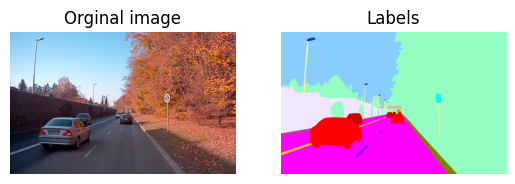

In [10]:
image_id = 1

image_file = list(DATA_PATH.rglob('*_camera_*.png'))[image_id]

label_file = get_label_file(image_file)

org_image = Image.open(image_file)
label_image = Image.open(label_file)

display_images([
    (org_image, "Orginal image"),
    (label_image, "Labels"),
])

# Dataloader and Model Classes

Dataset class - responsible for reading files from A2D2 dataset and returning datapoints. Each datapoint consist of an image with respective list of labels, binary masks and bounding boxes.

In [11]:
class A2D2(torch.utils.data.Dataset):
    def __init__(self, data_location, classes, image_transform=None, label_transform=None):
        self.classes = classes
        self.images = [
            image_file
            for image_file in data_location.rglob('*_camera_*.png')
        ]
        self.image_transform = image_transform
        self.label_transform = label_transform

        self.color_id = []
        for class_dict in self.classes:
            for color in class_dict['colors']:
                self.color_id.append((color, class_dict['id']))

    def __getitem__(self, index):
        '''
        index: the index of item
        Return image and its labels
        '''
        return self.get_image(index, self.image_transform), self.get_target(index, self.label_transform)

    def get_image(self, index, image_transform):
        image_file = self.images[index]
        input_image = Image.open(image_file)
        if image_transform:
            input_image = image_transform(input_image)
        return input_image

    def get_target(self, index, label_transform):
        label_file = get_label_file(self.images[index])

        label_image = Image.open(label_file)
        if label_transform:
            label_image = label_transform(label_image)

        # create masks
        masks_list = [
            get_masks(label_image, color, class_id)
            for color, class_id in self.color_id
        ]
        masks = np.maximum.reduce(masks_list, keepdims=True)

        return masks

    def __len__(self):
        return len(self.images)

Data Module class - responsible for creating training and validation dataloaders. Additionally stores definitions of image transformations applied to input data.

In [12]:
from abc import ABC

class A2D2DataModule(ABC):
    def __init__(self, data_location, class_list, batch_size):
        super().__init__()

        self.data_location = data_location
        self.classes = get_classes(data_location, class_list)
        self.batch_size = batch_size

        self.image_visualization_transform = transforms.Compose([
            transforms.Resize((192,160)),
            transforms.ToTensor(),
        ])
        self.image_transform = transforms.Compose([
            self.image_visualization_transform,
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        self.label_transform = transforms.Compose([
            transforms.Resize(
                (192,160),
                interpolation=transforms.InterpolationMode.NEAREST
            ),
            transforms.PILToTensor(),
        ])

    def setup(self, stage=None):
        full_dataset = A2D2(self.data_location, self.classes,
                            self.image_transform, self.label_transform)
        train_ds_len = int(0.9*len(full_dataset))
        self.train_ds, self.valid_ds = torch.utils.data.random_split(
            full_dataset, (train_ds_len, len(full_dataset)-train_ds_len))

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=self.train_ds,
            batch_size=self.batch_size,
            sampler=torch.utils.data.DistributedSampler(self.train_ds),
            num_workers=32,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=self.valid_ds,
            batch_size=self.batch_size,
            num_workers=32,
        )


The main model class specific to A2D2 dataset, NNUnetA2D2, is a subclass of the NNUnet class in PyTorch/computer_vision/segmentation/Unet from Model-References repository.

In [13]:
import torch.nn as nn
from models.unet import UNet
from models.loss import Loss
from models.metrics import Dice
from models.nn_unet import NNUnet
from dllogger import JSONStreamBackend, Logger, StdOutBackend, Verbosity
from utils.utils import mark_step

def get_dllogger(results):
    if not os.path.exists(results):
        os.mkdir(results)
    if torch.distributed.is_initialized():
        torch.distributed.barrier()
    return Logger(
        backends=[
            JSONStreamBackend(Verbosity.VERBOSE, os.path.join(results, "logs.json")),
            StdOutBackend(Verbosity.VERBOSE, step_format=lambda step: f"Epoch: {step} "),
        ]
    )

class NNUnetA2D2(NNUnet):
    def __init__(self, args):
        super(NNUnet, self).__init__()
        self.args = args
        if hasattr(self, 'save_hyperparameters'):
            self.save_hyperparameters()

        self.patch_size = [192,160]
        self.n_class = 37 #excluding background
        self.model = UNet(
            in_channels=3,
            n_class=38, # including background
            kernels=[[3,3],[3,3],[3,3],[3,3],[3,3],[3,3]],
            strides=[[1,1],[2,2],[2,2],[2,2],[2,2],[2,2]],
            dimension=self.args.dim,
            residual=self.args.residual,
            attention=self.args.attention,
            drop_block=self.args.drop_block,
            normalization_layer=self.args.norm,
            negative_slope=self.args.negative_slope,
            deep_supervision=self.args.deep_supervision,
            )

        self.loss = Loss(self.args.focal)
        self.dice = Dice(self.n_class)
        self.best_sum = 0
        self.best_sum_epoch = 0
        self.best_dice = self.n_class * [0]
        self.best_epoch = self.n_class * [0]
        self.best_sum_dice = self.n_class * [0]
        self.learning_rate = args.learning_rate
        self.tta_flips = [[2], [3], [2, 3]]
        self.test_idx = 0
        self.test_imgs = []
        if self.args.exec_mode in ["train", "evaluate"]:
            self.dllogger = get_dllogger(args.results)

    def configure_optimizers(self):
        self.model = self.model.to(torch.device('hpu'))
        from habana_frameworks.torch.hpex.optimizers import FusedAdamW
        optimizer = FusedAdamW(self.parameters(), lr=self.learning_rate, eps=1e-08, weight_decay=self.args.weight_decay)
        scheduler = None
        opt_dict = {"optimizer": optimizer, "monitor": "val_loss"}
        return opt_dict
    
    def validation_step(self, batch, batch_idx):
        self.current_epoch = self.trainer.current_epoch
        if self.current_epoch < self.args.skip_first_n_eval:
            return None
        img, lbl = batch[0], batch[1]
        img, lbl = img.to(torch.device("hpu"), non_blocking=False), lbl.to(torch.device("hpu"), non_blocking=False)
        pred = self.forward(img)
        self.dice.update(pred, lbl[:, 0])
        loss = self.loss(pred, lbl)
        mark_step(self.args.run_lazy_mode)
        return {"val_loss": loss}
    
    def get_train_data(self, batch):
        img, lbl = batch[0], batch[1]
        img, lbl = img.to(torch.device("hpu"), non_blocking=False), lbl.to(device=torch.device("hpu"), dtype=torch.float32, non_blocking=False)
        return img, lbl
    
    def forward(self, img):
        return self.model(img)


Then set hyperparameters for training and build a trainer class for A2D2 dataset based on the trainer class in PyTorch/computer_vision/segmentation/Unet/pytorch/ from Model-References repository.

In [14]:
from types import SimpleNamespace
hparams = SimpleNamespace()

from argparse import Namespace
hparams.args = Namespace()
hparams.args.exec_mode = 'train'
hparams.args.benchmark = False
hparams.args.results = "./training_results"
hparams.args.task = "01"
hparams.args.hpus = 1
hparams.args.gpus = 0
hparams.args.learning_rate = 0.001
hparams.args.seed = 1
hparams.args.num_workers = 8
hparams.args.norm = 'instance'
hparams.args.affinity = 'disabled'
hparams.args.dim = 2 #unet dim
hparams.args.optimizer = 'fusedadamw'
hparams.args.batch_size = 64
hparams.args.residual = False
hparams.args.attention = False
hparams.args.drop_block = False
hparams.args.negative_slope = 0.01
hparams.args.deep_supervision = False #True
hparams.args.focal = False
hparams.args.patience = 100
hparams.args.scheduler = None
hparams.args.weight_decay = 0.0001
hparams.args.min_epochs = 2
hparams.args.max_epochs = 3
hparams.args.gradient_clip = False
hparams.args.progress_bar_refresh_rate = 25
hparams.args.run_lazy_mode = True
hparams.args.skip_first_n_eval = 0
hparams.args.val_batch_size = 64
hparams.args.bucket_cap_mb = 125
hparams.args.is_autocast = False

hparams.data_module = A2D2DataModule(DATA_PATH, CLASS_LIST, hparams.args.batch_size)
hparams.data_module.setup()

from pytorch.trainer import Trainer
from pytorch.early_stopping_unet import EarlyStopping
import time

class TrainerA2D2(Trainer):
    def __init__(self, hparams):
        Trainer.__init__(self, hparams)
    
    def save_ckpt(self, ckpt_path, model, num_epoch):
        print(f"Saving weights to {ckpt_path}", end="\r")
        ckpt_state = {
                "start_epoch": num_epoch + 1,
                "model": model.state_dict(),
        }
        if not os.path.exists(ckpt_path):
            os.makedirs(ckpt_path)
        filename = os.path.join(ckpt_path, str(num_epoch) + "_ckpt.pth")
        torch.save(ckpt_state, filename)

    def fit(self, model:"NNUnet", hparams) -> None:
            model.trainer = self
            self.earlystopping =  EarlyStopping(monitor="dice_sum", patience=model.args.patience, verbose=True, mode="max")
            self.earlystopping.setup(self)
            self.optimizer = hparams.opt_dict['optimizer']
            self.scheduler = hparams.opt_dict['lr_scheduler'] if 'lr_scheduler' in  hparams.opt_dict else None

            self.train_dataloaders.append(hparams.data_module.train_dataloader())
            self.val_dataloaders.append(hparams.data_module.val_dataloader())
            for self.current_epoch in range(model.args.max_epochs):
                time_1 = time.time()
                train_output_loss = self._implement_train(model, hparams)
                val_output = self._implement_validate(model, hparams)
                
                self.save_ckpt(hparams.args.results, model, self.current_epoch)
                
                self.scheduler_step(val_output['val_loss'])

                time_2 = time.time()
                time_interval = time_2 - time_1
                print(f"End epoch: {self.current_epoch} with time interval: {time_interval:.3f} secs")

                if self.current_epoch >= model.args.min_epochs:
                     self.earlystopping.on_validation_end(self, val_output['dice_sum'])
                     if self.earlystopping.stopped_epoch == self.current_epoch:
                        print(f"Training stopped with epoch: {self.current_epoch}")
                        break
    
hparams.model = NNUnetA2D2(hparams.args).to('hpu')

hparams.world_size = hparams.args.hpus
hparams.hpus = hparams.args.hpus

hparams.opt_dict = hparams.model.configure_optimizers()

hparams.trainer = TrainerA2D2(hparams)


=============================HABANA PT BRIDGE CONFIGURATION =========================== 
 PT_HPU_LAZY_MODE = 1
 PT_HPU_LAZY_EAGER_OPTIM_CACHE = 1
 PT_HPU_ENABLE_COMPILE_THREAD = 0
 PT_HPU_ENABLE_EXECUTION_THREAD = 1
 PT_HPU_ENABLE_LAZY_EAGER_EXECUTION_THREAD = 1
 PT_ENABLE_INTER_HOST_CACHING = 0
 PT_ENABLE_INFERENCE_MODE = 1
 PT_ENABLE_HABANA_CACHING = 1
 PT_HPU_MAX_RECIPE_SUBMISSION_LIMIT = 0
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_MAX_COMPOUND_OP_SIZE_SS = 10
 PT_HPU_ENABLE_STAGE_SUBMISSION = 1
 PT_HPU_STAGE_SUBMISSION_MODE = 2
 PT_HPU_PGM_ENABLE_CACHE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 0
 PT_HCCL_SLICE_SIZE_MB = 16
 PT_HCCL_MEMORY_ALLOWANCE_MB = 0
 PT_HPU_INITIAL_WORKSPACE_SIZE = 0
 PT_HABANA_POOL_SIZE = 24
 PT_HPU_POOL_STRATEGY = 5
 PT_HPU_POOL_LOG_FRAGMENTATION_INFO = 0
 PT_ENABLE_MEMORY_DEFRAGMENTATION = 1
 PT_ENABLE_DEFRAGMENTATION_INFO = 0
 PT_HPU_ENABLE_SYNAPSE_LAYOUT_HANDLING = 1
 PT_HPU_ENABLE_SYNAPSE_OUTPUT_PERMUTE = 1
 PT_HPU_ENABLE_VALID_DATA_RANGE_C

# Train Model on Single Gaudi Card

We can now train the model for A2D2 dataset using the TrainerA2D2 class. The following cell will initiate training.

In [15]:
os.environ['framework']='NPT'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29500'

torch.distributed.init_process_group('hccl', rank=0, world_size=hparams.args.hpus)
hparams.trainer.fit(hparams.model.to(torch.device('hpu')), hparams)

Train Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 722/722 [04:01<00:00,  3.00it/s]


Rank: 0, Batch: 721, Train Loss is: 1.673


Validation Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [01:09<00:00,  1.17it/s]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/apply_func.py:31: LightningDeprecationWarning: `pytorch_lightning.utilities.apply_func.apply_to_collection` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_utilities.core.apply_func.apply_to_collection` instead.
  rank_zero_deprecation(


DLL 2023-03-21 22:36:52.459543 - Epoch: 0  mean dice : 41.78  TOP_mean : 41.78  L1 : 79.96  L2 : 47.06  L3 : 0.0  L4 : 0.0  L5 : 100.0  L6 : 26.35  L7 : 1.23  L8 : 0.01  L9 : 98.77  L10 : 51.68  L11 : 62.45  L12 : 0.63  L13 : 67.18  L14 : 86.42  L15 : 36.72  L16 : 53.09  L17 : 0.0  L18 : 8.98  L19 : 0.02  L20 : 41.98  L21 : 14.98  L22 : 0.0  L23 : 28.72  L24 : 14.81  L25 : 3.7  L26 : 88.94  L27 : 15.67  L28 : 63.27  L29 : 97.07  L30 : 0.0  L31 : 1.17  L32 : 47.64  L33 : 92.32  L34 : 97.86  L35 : 78.97  L36 : 39.51  L37 : 98.77  TOP_L1 : 79.96  TOP_L2 : 47.06  TOP_L3 : 0.0  TOP_L4 : 0.0  TOP_L5 : 100.0  TOP_L6 : 26.35  TOP_L7 : 1.23  TOP_L8 : 0.01  TOP_L9 : 98.77  TOP_L10 : 51.68  TOP_L11 : 62.45  TOP_L12 : 0.63  TOP_L13 : 67.18  TOP_L14 : 86.42  TOP_L15 : 36.72  TOP_L16 : 53.09  TOP_L17 : 0.0  TOP_L18 : 8.98  TOP_L19 : 0.02  TOP_L20 : 41.98  TOP_L21 : 14.98  TOP_L22 : 0.0  TOP_L23 : 28.72  TOP_L24 : 14.81  TOP_L25 : 3.7  TOP_L26 : 88.94  TOP_L27 : 15.67  TOP_L28 : 63.27  TOP_L29 : 97.0

Train Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 722/722 [03:51<00:00,  3.12it/s]


Rank: 0, Batch: 721, Train Loss is: 1.139


Validation Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:43<00:00,  1.88it/s]

 val_loss 1.07:80, Val Loss is: 1.070
 dice_sum 1960.33



End epoch: 1 with time interval: 277.589 secs


Train Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 722/722 [03:34<00:00,  3.37it/s]


Rank: 0, Batch: 721, Train Loss is: 0.981


Validation Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:43<00:00,  1.85it/s]

DLL 2023-03-21 22:45:52.316315 - Epoch: 2  mean dice : 57.74  TOP_mean : 57.74  L1 : 88.76  L2 : 76.88  L3 : 31.01  L4 : 31.17  L5 : 100.0  L6 : 52.08  L7 : 1.68  L8 : 60.33  L9 : 98.77  L10 : 64.52  L11 : 72.57  L12 : 20.94  L13 : 78.87  L14 : 86.42  L15 : 62.54  L16 : 53.09  L17 : 4.09  L18 : 32.32  L19 : 49.85  L20 : 41.98  L21 : 39.59  L22 : 30.19  L23 : 47.99  L24 : 17.28  L25 : 2.47  L26 : 93.58  L27 : 47.4  L28 : 77.29  L29 : 98.2  L30 : 44.95  L31 : 46.49  L32 : 64.7  L33 : 95.13  L34 : 98.35  L35 : 86.52  L36 : 39.51  L37 : 98.77  TOP_L1 : 88.76  TOP_L2 : 76.88  TOP_L3 : 31.01  TOP_L4 : 31.17  TOP_L5 : 100.0  TOP_L6 : 52.08  TOP_L7 : 1.68  TOP_L8 : 60.33  TOP_L9 : 98.77  TOP_L10 : 64.52  TOP_L11 : 72.57  TOP_L12 : 20.94  TOP_L13 : 78.87  TOP_L14 : 86.42  TOP_L15 : 62.54  TOP_L16 : 53.09  TOP_L17 : 4.09  TOP_L18 : 32.32  TOP_L19 : 49.85  TOP_L20 : 41.98  TOP_L21 : 39.59  TOP_L22 : 30.19  TOP_L23 : 47.99  TOP_L24 : 17.28  TOP_L25 : 2.47  TOP_L26 : 93.58  TOP_L27 : 47.4  TOP_L28 

End epoch: 2 with time interval: 262.293 secs
Metric dice_sum improved. New best score: 2136.296


# Inference Examples

Finally, we can compare masks of inference examples between model prediction results and ground truth. The following source code loads the model with trained weights.

In [16]:
a2d2_datamodule = hparams.data_module
a2d2_datamodule.setup()
image_transform = a2d2_datamodule.image_transform
label_transform = a2d2_datamodule.label_transform

dataset = A2D2(DATA_PATH,  get_classes(DATA_PATH, CLASS_LIST),
                            image_transform, label_transform)

image_visualization_transform = a2d2_datamodule.image_visualization_transform

to_PIL = transforms.ToPILImage()

model = NNUnetA2D2(hparams.args).to(torch.device('hpu'))
checkpoint = torch.load((hparams.args.results) + '/' + str(hparams.args.max_epochs-1)+'_ckpt.pth')
model.load_state_dict(checkpoint['model'])
model.eval()

lookuptable = np.zeros((len(CLASS_LIST) + 1, 3)) # each row contains rgb for each class
for class_dict in a2d2_datamodule.classes:
    lookuptable[class_dict["id"]] = class_dict["colors"][0]

def argmax_to_rgb(result, lut):
    # [1, 192, 160] -> [3,192,160]
    if torch.is_tensor(result):
        result=result.cpu()
    rgb = lut[result[0, ...],:]
    rgb = torch.from_numpy(rgb).to(torch.int64)
    return rgb

This block perform inference on sample images and display the predicted masks with ground turh.

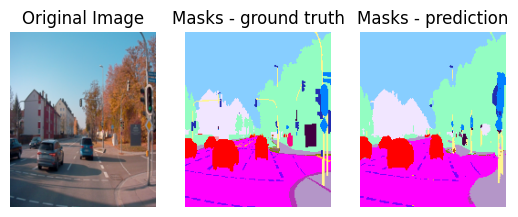

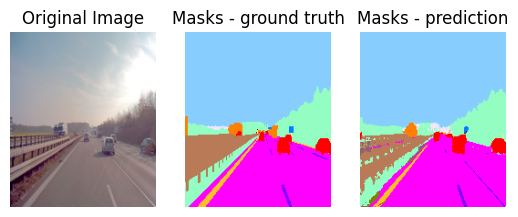

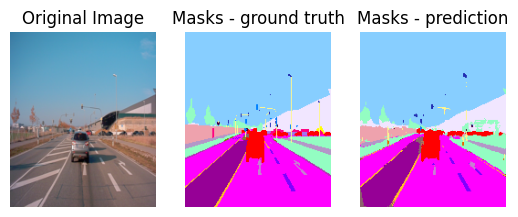

In [17]:
for image_id in [10,30,50]:
    inference_original = dataset.get_image(image_id, image_visualization_transform)
    inference_original = transforms.functional.convert_image_dtype(inference_original, torch.uint8)
    inference_normalized = dataset.get_image(image_id, image_transform)
    inference_normalized = inference_normalized.to(torch.device('hpu'))
    inference_target = dataset.get_target(image_id, label_transform)

    with torch.no_grad():
        result = model(torch.unsqueeze(inference_normalized,0))
        result = torch.nn.functional.softmax(result, dim=1) #having BNHW, after softmax one of N dim indicates a class of a mask
        result = torch.argmax(torch.nn.functional.softmax(result, dim=1), dim=1) #[1,192,160]

    rgb_pred = argmax_to_rgb(result,lookuptable)
    rgb_gt = argmax_to_rgb(inference_target,lookuptable)

    display_images([
            (to_PIL(inference_original), "Original Image"),
            (rgb_gt, "Masks - ground truth"),
            (rgb_pred, "Masks - prediction"),
    ])

# Distributed Training

We will use the following commands to run distributed training on 8 HPUs. The 8 HPUs training can be initiated using the `unet4.py` script available in the current directory.

**NOTE: Restart the kernel before running the next section of the notebook. Please make sure the PYTHONPATH environment variable includes the root of Model-References repository and the Unet folder**

In [ ]:
%env PYTHONPATH=./Model-References/PyTorch/computer_vision/segmentation/Unet:./Model-References:$PYTHONPATH

!python3 unet4.py --results ./results_8x --batch_size 8 --deep_supervision --max_epochs 20 --min_epochs 19

Running more epochs with distributed training improves accuracy. With 20 epochs of distributed training, the model achieved validation dice sum of 2639.

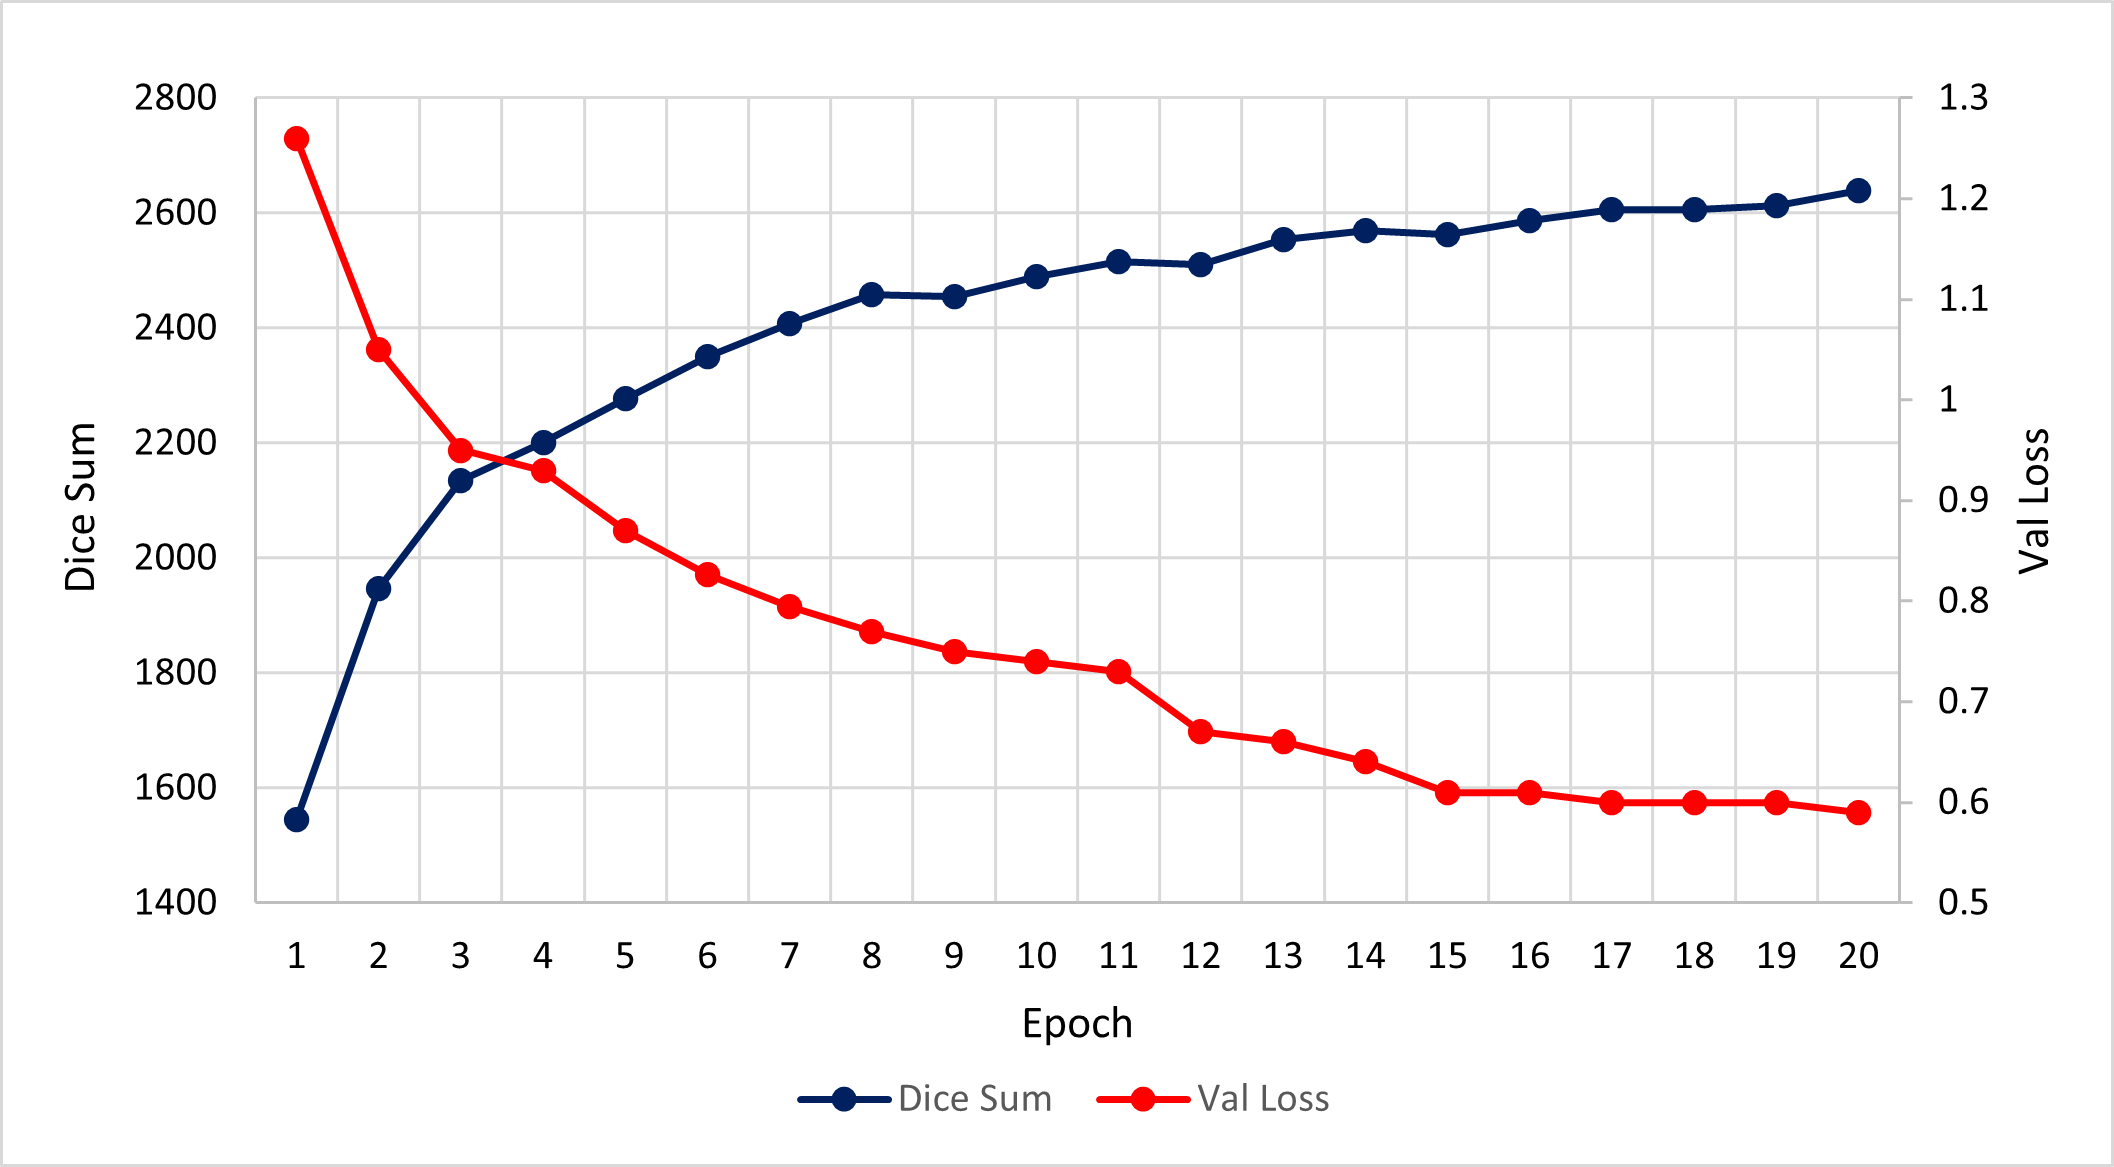